# Background

In the reviews provided, Reviewer 1 requested an analysis that showed that reassortment is favoured between different wild bird species. In the review, one specific example brought up was about genome transfer (clonal & reassortment) between gulls and mallards. In this notebook, I attempt this analysis.

In [100]:
import networkx as nx
import custom_funcs as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('paper')
sns.set_style('white')

%matplotlib inline

from joblib import Parallel, delayed
from time import time
from tqdm import tqdm

/Users/ericmjl/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [58]:
# Read in the graph data and clean it.
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [59]:
G.nodes(data=True)[3]

('A/swine/Hong Kong/2461/1994',
 {'collection_date': Timestamp('1994-04-18 00:00:00'),
  'country': 'Hong Kong',
  'host_species': 'Swine',
  'reassortant': False,
  'subtype': 'H1N1'})

In [62]:
# Encode any gull species as "Gull" in the "host_label" field.
for n, d in G.nodes(data=True):
    if d['host_species'] == 'Gull' or 'Gull' in d['host_species']:
        G.node[n]['host_label'] = 'Gull'
    elif d['host_species'] == 'Mallard':
        G.node[n]['host_label'] = 'Mallard'
    else:
        G.node[n]['host_label'] = 'Unknown'

In [63]:
[n for n, d in G.nodes(data=True) if d['host_label'] == 'Gull']

['A/herring gull/Iceland/1359/2011',
 'A/black-headed gull/Republic of Georgia/2/2012',
 'A/laughing gull/NJ/276/1989',
 'A/gull/Delaware/AI09-453/2009',
 'A/lesser black-backed gull/Iceland/145/2010',
 'A/black-headed gull/Sweden/87533/2009',
 'A/black-headed gull/Sweden/1/2005',
 'A/California gull/California/1196P/2013',
 'A/herring gull/New Jersey/AI09-335/2009',
 'A/black-headed gull/Republic of Georgia/4/2012',
 'A/black-headed gull/Republic of Georgia/2/2011',
 'A/herring gull/Delaware Bay/2617/1987',
 'A/laughing gull/New Jersey/75/1985',
 'A/black-headed gull/Republic of Georgia/8/2012',
 'A/laughing gull/New Jersey/177/1990',
 'A/laughing gull/New Jersey/180/1990',
 'A/herring gull/Iceland/1342/2011',
 'A/yellow-legged gull/Republic of Georgia/1/2011',
 'A/ring-billed gull/Quebec/G139/2010',
 'A/laughing gull/New York/AI00-470/2000',
 'A/laughing gull/Delaware Bay/261/1991',
 'A/wild bird/Chile/1805/2008',
 'A/herring gull/Mongolia/454/2008',
 'A/black-headed gull/Republic of

In [64]:
'Gull' in 'Herring Gull'

True

In [65]:
set([d['host_species'] for n, d in G.nodes(data=True)])

{'American Black Duck',
 'American Green-Winged Teal',
 'American Wigeon',
 'Aquatic Bird',
 'Avian',
 'Babbler',
 'Baikal Teal',
 'Bar-Headed Goose',
 'Barn Swallow',
 'Barnacle Goose',
 "Bewick's Swan",
 'Bird',
 'Black Duck',
 'Black Scoter',
 'Black-Billed Magpie',
 'Black-Headed Gull',
 'Blue-Winged Teal',
 'Brown-Headed Gull',
 'Bufflehead',
 'Camel',
 'Canada Goose',
 'Canvasback',
 'Chicken',
 'Chinese Francolin',
 'Chukar',
 'Cinnamon Teal',
 'Common Coot',
 'Common Eider',
 'Common Goldeneye',
 'Common Murre',
 'Common Scoter',
 'Condor',
 'Coot',
 'Crane',
 'Crow',
 'Dog',
 'Domestic Cat',
 'Dove',
 'Duck',
 'Dunlin',
 'Eagle',
 'Eagle-Owl',
 'Egret',
 'Emu',
 'Environment',
 'Falcon',
 'Ferret',
 'Finch',
 'Flycatcher',
 'Gadwall',
 'Garganey',
 'Glaucous Gull',
 'Goose',
 'Great Black-Headed Gull',
 'Great Crested Grebe',
 'Greater Scaup',
 'Greater White-Fronted Goose',
 'Grebe',
 'Green-Winged Teal',
 'Grey Heron',
 'Guinea Fowl',
 'Guineafowl',
 'Gull',
 'Heron',
 'Herr

In [66]:
def counts_reassortant_domain_graph(G, node_attr):
    """
    Computes the weighted counts of reassortant edges when going between different node attributes.
    
    Returns a "domain graph" with counts of weighted reasosrtant edges and sum weighted edges.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n][node_attr]
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc][node_attr]
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph

In [67]:
# Compute the proportion reassortant across different host class pairs.
hg = counts_reassortant_domain_graph(G, 'host_label')

hg.edges(data=True)

[('Gull',
  'Gull',
  {'p_reassortant': 0.2222222222222222, 'reassortant': 12.0, 'total': 54.0}),
 ('Gull',
  'Mallard',
  {'p_reassortant': 0.5714285714285714, 'reassortant': 2.0, 'total': 3.5}),
 ('Gull',
  'Unknown',
  {'p_reassortant': 0.4235294117647059, 'reassortant': 18.0, 'total': 42.5}),
 ('Mallard',
  'Gull',
  {'p_reassortant': 0.8695652173913043, 'reassortant': 10.0, 'total': 11.5}),
 ('Mallard',
  'Mallard',
  {'p_reassortant': 0.23864756477943258,
   'reassortant': 294.5666666666666,
   'total': 1234.3166666666666}),
 ('Mallard',
  'Unknown',
  {'p_reassortant': 0.43752248710739206,
   'reassortant': 390.8690476190477,
   'total': 893.3690476190473}),
 ('Unknown',
  'Gull',
  {'p_reassortant': 0.45544554455445546, 'reassortant': 23.0, 'total': 50.5}),
 ('Unknown',
  'Mallard',
  {'p_reassortant': 0.38963245348692654,
   'reassortant': 313.43333333333317,
   'total': 804.433333333333}),
 ('Unknown',
  'Unknown',
  {'p_reassortant': 0.07361793995931051,
   'reassortant': 11

In [68]:
# A helper function for computing the null distribution.
def null_proportion_domain_graph_reassortant(G, node_attr, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, node_attr, equally)
    hg_graph_shuf = counts_reassortant_domain_graph(G_shuffled, node_attr)
    
    return hg_graph_shuf

In [72]:
# Compute the null distribution.
### CAUTION! YOU WILL HAVE TO WAIT 3 MINUTES FOR THIS TO FINISH!
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_domain_graph_reassortant)(G, 'host_label', equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

366.61181807518005


As shown in the analysis, there are insufficient numbers to compare reassortment between Mallards and Gulls (of any species). Within species, it is possible to do so for Mallards but not Gulls. At `p_reassortant` = 0.23, I would expect this (intuitively) to be greater than the null.

In [86]:
# Summarize the proportion reassortant distribution under null.
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in tqdm(list_of_hg_graphs):
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

In [89]:
summaryG = distr_null_p_reassortant(results)

In [91]:
# Remove "unknowns" from consideration
for n, d in summaryG.nodes(data=True):
    if 'Unknown' in n:
        summaryG.remove_node(n)
summaryG.edges(data=True)

[('Gull',
  'Gull',
  {'p_reassortant': [0.11186105273958351,
    0.11743158554559348,
    0.11460536974882943,
    0.1376971925510451,
    0.13139767167300093,
    0.11151050856179888,
    0.1166016162651999,
    0.10238016976912594,
    0.1172233233031455,
    0.11860438572451573,
    0.103870413287675,
    0.12854558634994304,
    0.11134131568376841,
    0.11956246205210017,
    0.10781202399673226,
    0.12886973200718627,
    0.11978802152370584,
    0.1171926551393703,
    0.11306710996422856,
    0.1200804495052311,
    0.12272865986924143,
    0.13287737523436713,
    0.12724237644177314,
    0.11671203108180446,
    0.1166801144981119,
    0.10390234209478312,
    0.11036922618196054,
    0.1252267983129836,
    0.10805040804826795,
    0.12452595308290461,
    0.1151475365438372,
    0.10600259597879937,
    0.12647666882994846,
    0.11994100977419073,
    0.10682902516765425,
    0.1210106919493094,
    0.11325430679155178,
    0.11894379480211498,
    0.11813527782860041,

In [95]:
# Grab out the "null" model statistics.
means = []  # mean of the distribution under null.
stds  = []  # standard deviation of distribution under null.
names = []  # names
# grab out the 1st, 5th, 95th and 99th percentile of null distribution
percs = dict()
for p in [0.5, 5, 95, 99.5]:
    percs[p] = []

name_map = {'Gull': 'Gull',
            'Mallard': 'Mallard'}

# Reverse name_map for convenience
key_map = {v:k for k, v in name_map.items()}

for sc, sk, d in sorted(summaryG.edges(data=True), key=lambda x:(x[0], x[1])):
    mean = np.mean(d['p_reassortant'])
    std = np.std(d['p_reassortant'])

    names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
    means.append(mean)
    stds.append(std)
    for p in [0.5, 5, 95, 99.5]:
        percs[p].append(np.percentile(d['p_reassortant'], p))

In [96]:
# Compile the "data" statistics.
data = []
names_data = []
log10weights = []
log10reassort = []
log10clonal = []
for sc, sk, d in sorted(hg.edges(data=True), key=lambda x:(x[0], x[1])):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        names_data.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        data.append(d['p_reassortant'])
        log10weights.append(np.log10(d['total']))
        log10reassort.append(np.log10(d['reassortant']))
        log10clonal.append(np.log10(d['total'] - d['reassortant']))
data

[0.2222222222222222,
 0.5714285714285714,
 0.8695652173913043,
 0.23864756477943258]

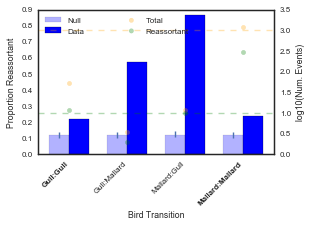

In [115]:
# Plot data vs. null model.
fig = plt.figure(figsize=(4,3))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, 
       color='blue', 
       label='Null', 
       #yerr=np.array(stds)*3, 
       yerr=[np.array(means) - percs[0.5],
             percs[99.5] - np.array(means)],
       alpha=0.3)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Proportion Reassortant')
ax.set_xlabel('Bird Transition')

for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    if log10weights[i] > 3 or log10reassort[i] > 1:
        label.set_weight('bold')

ax2 = ax.twinx()
ax2.scatter(ind+width, log10weights, color='orange', label='Total', alpha=0.3)
ax2.scatter(ind+width, log10reassort, color='green', label='Reassortant', alpha=0.3)
ax2.set_ylabel('log10(Num. Events)')
ax.legend(loc='upper left')
ax2.legend(loc='upper center')

ax2.axhline(y=1, color='green', alpha=0.3, linestyle='--')
ax2.axhline(y=3, color='orange', alpha=0.3, linestyle='--')

# ax.annotate('B', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
# plt.legend()
plt.subplots_adjust(left=0.10, right=0.92, bottom=0.23)
plt.savefig('figures/Proportion Reassortant Gull Mallard.pdf', bbox_inches='tight')